# Pylops - Least squares migration - old vs new

### Author: M.Ravasi

Here we compare the old and new Kirchhoff... the main difference arises from how traveltimes are stored, the old is more demanding than the latter..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff_largemem import Kirchhoff as Kirchhoff_lm
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

from kirchhoff_old import _traveltime_table

## Model

Lets' create a model and geometry

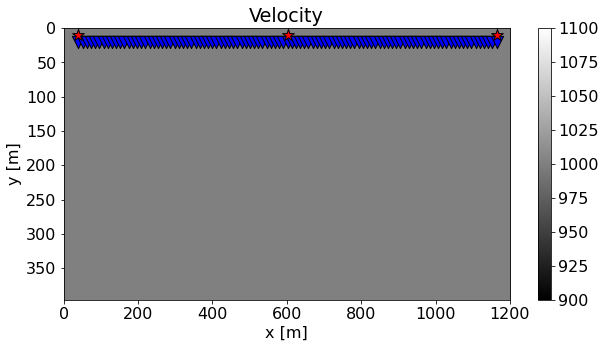

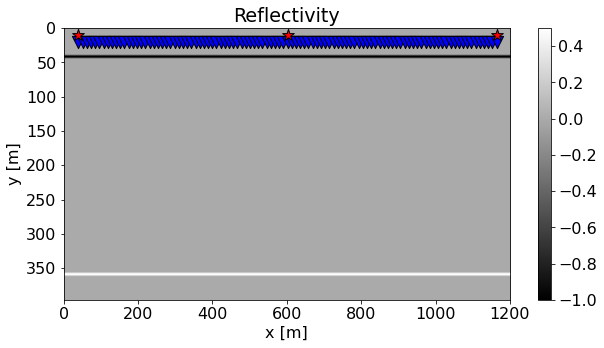

In [2]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
#refl[nx//2, 50] = -1
refl[:, 10] = -1
refl[:, -10] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 3
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
#ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

## Dynamic=False

In [3]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [4]:
kop = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', engine='numba')
dottest(kop)

trav = kop.trav_srcs.reshape(nx * nz, ns, 1) + kop.trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)
kop1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, trav=trav, mode='byot', engine='numba')
kop1_old = Kirchhoff_lm(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', engine='numba')

Done
Done1
Done1


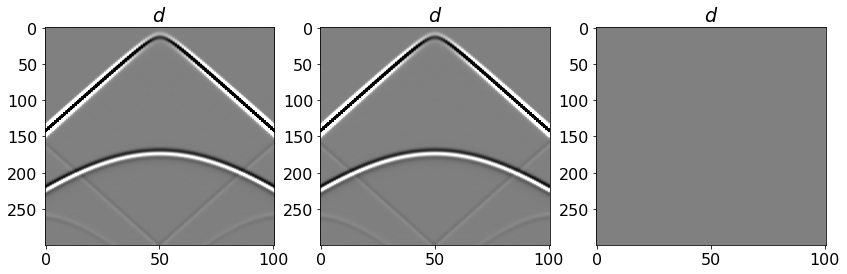

In [5]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)
print('Done')

d1 = kop1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)
print('Done1')

d1_old = kop1_old * refl.ravel()
d1_old = d1_old.reshape(ns, nr, nt)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d[ns//2, :, :300].T - d1[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$d$')
axs[2].axis('tight');

In [6]:
np.allclose(d,d1), np.allclose(d,d1_old)

(True, True)

Done
Done1
Done1


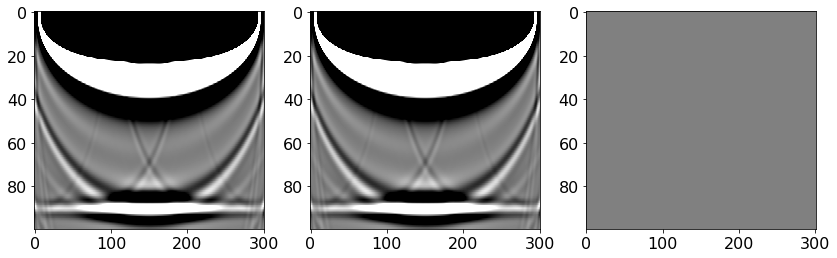

In [7]:
madj = kop.H * d.ravel()
madj = madj.reshape(nx, nz)
print('Done')

madj1 = kop1.H * d.ravel()
madj1 = madj1.reshape(nx, nz)
print('Done1')

madj1_old = kop1_old.H * d.ravel()
madj1_old = madj1_old.reshape(nx, nz)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(madj.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[0].axis('tight')
axs[1].imshow(madj1.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[1].axis('tight')
axs[2].imshow(madj.T-madj1.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[2].axis('tight');

In [8]:
np.allclose(madj,madj1),np.allclose(madj,madj1_old)

(True, True)

In [9]:
%timeit -n10 -r3 kop.matvec(refl.ravel())
%timeit -n10 -r3 kop1.matvec(refl.ravel())
%timeit -n10 -r3 kop1_old.matvec(refl.ravel())

32.5 ms ± 2.54 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
48 ms ± 5.62 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
66.4 ms ± 3.99 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [10]:
%timeit -n10 -r3 kop.H * d.ravel()
%timeit -n10 -r3 kop1.H * d1.ravel()
%timeit -n10 -r3 kop1_old.H * d1.ravel()

16.7 ms ± 613 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
17.4 ms ± 4.53 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
12.7 ms ± 599 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Dynamic=True

In [11]:
kop = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', dynamic=True, engine='numba')
dottest(kop)
kop1_old = Kirchhoff_lm(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', dynamic=True, engine='numba')

Done
Done1


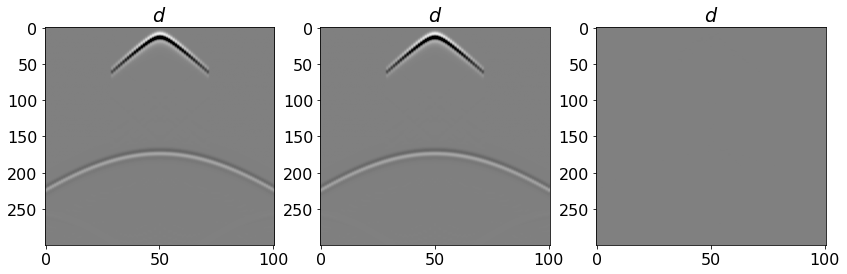

In [12]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)
print('Done')

d1 = kop1_old * refl.ravel()
d1 = d1.reshape(ns, nr, nt)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray', vmin=-1e-4, vmax=1e-4)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray', vmin=-1e-4, vmax=1e-4)
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d[ns//2, :, :300].T - d1[ns//2, :, :300].T, cmap='gray', vmin=-1e-4, vmax=1e-4)
axs[2].set_title(r'$d$')
axs[2].axis('tight');

In [13]:
np.allclose(d, d1)

True

Done
Done1


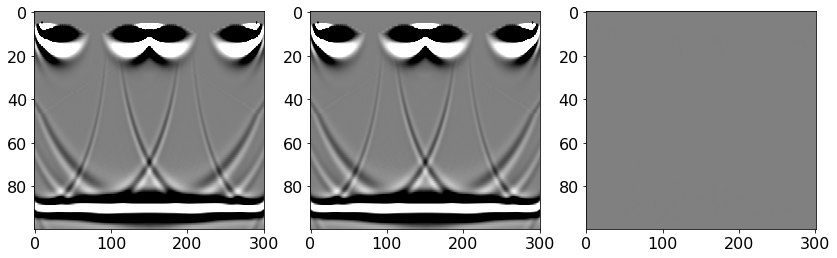

In [14]:
madj = kop.H * d.ravel()
madj = madj.reshape(nx, nz)
print('Done')

madj1 = kop1_old.H * d.ravel()
madj1 = madj1.reshape(nx, nz)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(madj.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[0].axis('tight')
axs[1].imshow(madj1.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[1].axis('tight')
axs[2].imshow(madj.T-madj1.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[2].axis('tight');

In [15]:
np.allclose(madj,madj1)

True

In [16]:
kop = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', angleaperture=None, dynamic=True, engine='numba')

trav = kop.trav_srcs.reshape(nx * nz, ns, 1) + kop.trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

trav = kop.trav_srcs.reshape(nx * nz, ns, 1) + kop.trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

dist = kop.dist_srcs.reshape(nx * nz, ns, 1) + kop.dist_recs.reshape(nx * nz, 1, nr)
dist = dist.reshape(nx * nz, ns * nr)

cosangle = np.cos(kop.angle_srcs).reshape(nx * nz, ns, 1) + \
        np.cos(kop.angle_recs).reshape(nx * nz, 1, nr)
cosangle = cosangle.reshape(nx * nz, ns * nr)

epsdist = 1e-2
amp = 1 / (dist + epsdist * np.max(dist))

amp *= np.abs(cosangle)
amp /= v0

kop1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='byot', trav=trav, amp=amp, 
                 dynamic=True, angleaperture=None, engine='numba')


Done
Done1


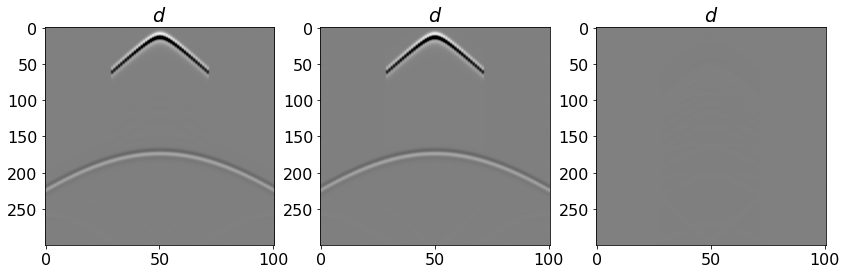

In [17]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)
print('Done')

d1 = kop1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray', vmin=-1e-4, vmax=1e-4)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray', vmin=-1e-4, vmax=1e-4)
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d[ns//2, :, :300].T - d1[ns//2, :, :300].T, cmap='gray', vmin=-1e-5, vmax=1e-5)
axs[2].set_title(r'$d$')
axs[2].axis('tight');

In [18]:
np.allclose(d, d1, atol=1e-4)

True

Done
Done1


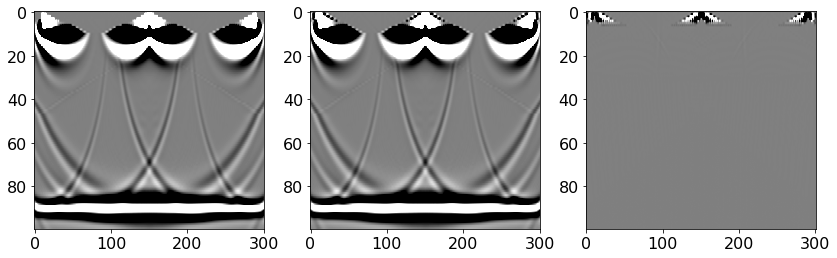

In [19]:
madj = kop.H * d.ravel()
madj = madj.reshape(nx, nz)
print('Done')

madj1 = kop1.H * d.ravel()
madj1 = madj1.reshape(nx, nz)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(madj.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[0].axis('tight')
axs[1].imshow(madj1.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[1].axis('tight')
axs[2].imshow(madj.T-madj1.T, cmap='gray', vmin=-1e-9, vmax=1e-9)
axs[2].axis('tight');

In [20]:
np.allclose(madj,madj1, atol=1e-4)

True

In [ ]:
%timeit -n3 -r3 kop * refl.ravel()
%timeit -n3 -r3 kop * refl.ravel()
%timeit -n3 -r3 kop1_old * refl.ravel()

513 ms ± 116 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
543 ms ± 110 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [22]:
%timeit -n3 -r3 kop.H * d.ravel()
%timeit -n3 -r3 kop1.H * d1.ravel()
%timeit -n3 -r3 kop1_old.H * d1.ravel()

73.8 ms ± 5.58 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
93.8 ms ± 5.17 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
71.9 ms ± 2.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
